In [1]:
%reset-f
%load_ext autoreload
%autoreload 2


import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

from textwrap import fill

import os, sys

from progress_reporter import *

In [2]:
#Parameters

smallfont = { 'size'   : 20}

font = {
    'size'   : 24}

fontlegend =font

boldfont = {      
     'weight': 'bold',
     'size'   : 24}

bigfont = {
     'weight': 'bold',
     'size'   : 30}

linewidth=1.5
height = .4     
     
#Formaters     
     
format_for_rank=lambda x :"{:1.0f}".format(x)

format_=lambda x :"{:g}%".format(fancy_round(100*np.abs(x)))


def normalizer(s):
    return (s-s.min())/(s.max()-s.min())
    

def file_name_formater(c):
    return c.lower().replace(" ","_").replace("\\","")

    
# drawing functions

linewidth=1.5
height = .4
istep = 0.8

def fancy_round(x,n=2):
    """displays numbers with a given number of total digits"""
    
    #special cases
    if np.isnan(x):
        return x
    
    if np.isinf(x):
        return (x)
    
    #number of digits before the dot in the original number
    if abs(x)<1:
        s=0
    else:
        s=int(np.log10(abs(x)))+1
    
    #output
    if s<n:
        return round(x,n-s)
    else:
        return int(round(x,n-s))
    
def draw_row(fig,key,c,i,j,step):
    """descrption, distribution, rank and progress needed"""

    number_type = info["number_type"][key]
    xoc = df_with_sens.ix[c,key]

    is_single =  key in single_values_set

    if np.sign(step.ix[c,key])>0:
        color="blue"
        s=1
        difficulty = step.ix[c,key] /(upper_bound[key] -xoc)
    else:
        #color="red"
        color="blue"
        s=-1
        difficulty = step.ix[c,key]/(lower_bound[key]-xoc)

    step_color = "DarkOrange"
    if difficulty>10:
        step_color="DarKRed"
    if difficulty<1:
        step_color="DarkGreen"
    
    #format_for_der =lambda x :"{:1.2f} pt".format(x)

    anotate_distri(fig,key,c,i,j,color)
    if not is_single: 
        draw_distri(fig,key,i,j,color,info.ix[key,"bandwith"],height,linewidth)
    
    #formaters
    if number_type=="simple":
        format_for_step=lambda x :"{: g}".format(fancy_round(x))
    else:
        #format_for_step=lambda x :"{: g} pt".format(fancy_round(100*x))
        format_for_step=lambda x :"{: g}".format(fancy_round(100*x))
    
    #Progress needed (with actual minus sign)
    fig.text(j+1.85,i,format_for_step(step.ix[c,key]).replace("-","−"),fontdict=font,horizontalalignment='center',color=step_color)
         
    '''if not is_single:
        #rank
        r=rank.ix[df_with_sens.ix[c,"original_country"],key]
        ar=.5*(r*(s+1) + (1+n-r)*(1-s))
        the_sring = format_for_rank(ar)
    else:
        the_sring = " "
    plt.text(1.75,i,the_sring,fontdict=font,horizontalalignment='center')''' 

    return i+istep


def draw_seprarator(fig,i,j):
    """horizontal grey line"""
    sep_steps=.08
    i+=sep_steps
    ex=j+np.array([-2,2.5])
    sep_i  = i-0.35
    fig.plot(ex, sep_i+0*ex, color="#aaaaaa",linewidth=1,clip_on=False)
    return i+sep_steps,sep_i
 
def draw_conector(fig,gauche,milieu,droite,bas,haut):
    fig.plot([gauche,milieu],[bas, bas],color="gray")
    fig.plot([milieu,milieu],[bas ,haut],color="gray")
    fig.plot([milieu,droite],[haut ,haut],color="gray")
 
def write_titles(fig,i,j,second_title):
    #titles
    #plt.text(5.5,i-.15,"Impact \non resilience",fontdict=font, horizontalalignment='center')
    #plt.text(1.75,i-.15,"Rank",fontdict=font, horizontalalignment='center')
    fig.text(j+1.85,i-.15,second_title,fontdict=font, horizontalalignment='center')
   

def draw_other_zone(fig,keyname,resilience_keys,c,i,j,steps_needed,improve_obj):
    #resilience drivers
    for key in resilience_keys:
        #progress_reporter(key)
        i=draw_row(fig,key,c,i,j,steps_needed)
        

    if False:    
        #separator
        i,resi_sep_i= draw_seprarator(fig,i,j)

        #driver
        draw_distri(fig,keyname,i,j,"Blue",.3,height,linewidth)
        anotate_distri(fig,keyname,c,i,j,"Blue")
    else:
        resi_sep_i=i-.3
        
        
    if np.sign(improve_obj)<0:
        improve_word = "improve\n"
    else:
        improve_word = "reduce\n"


    write_titles(fig,i,j,"To "+improve_word+info.ix[keyname,"descriptor"].replace("Asset ","").lower()+"\nby "+format_(improve_obj))
           
    return i,resi_sep_i
    
def draw_risk_zone(fig,risk_keys,c,i,j,steps_needed):
    flag= True
    #risk drivers
    for key in risk_keys:
        if key in ["v_shew", "resilience"]:
            if flag:
                i_bot_in_risk = i
                flag=False
            else:
                i_top_in_risk = i   
        i=draw_row(fig,key,c,i,j,steps_needed)    

    #separator
    i,risk_sep_i= draw_seprarator(fig,i,j)

    #risk
    draw_distri(fig,"risk",i,j,"Blue",.3,height,linewidth)
    anotate_distri(fig,"risk",c,i,j,"Blue")

    write_titles(fig,i,j,"Change needed\nto reduce\nrisk by 10%")  
    return i, risk_sep_i,i_bot_in_risk,i_top_in_risk
    
    
t=np.linspace(0,1,100)

def draw_distri(fig,key,i,j,color,bandwith,height,linewidth):
    """distribution"""
   
    x = (df_original[key]-lower_bound[key])/(upper_bound[key]-lower_bound[key])
    #all countries distribution
    y=gaussian_kde(x, bandwith)(t)
    y=height*y/y.max() 
    fig.plot(j+t, i+y,color=color,linewidth=linewidth)
    
    

def anotate_distri(fig,key,c,i,j,color,other_description=None): 
    """dot where the country stands, bounds, and description of sub-indicator"""
    number_type=info["number_type"][key]
    
    legend_mode = other_description is not None
    
    
    
    if number_type=="percent":
        format_for_val=lambda x :"{:2.0f}%".format(100*x)
        format_for_bound=lambda x :"{:2.0f}".format(100*x)
    elif number_type=="small_percent":
        format_for_bound=lambda x :"{:2.0f}".format(100*x)
        format_for_val=lambda x :"{}%".format(fancy_round(100*x,2))
    elif number_type=="simple":
        format_for_val=lambda x :"{:2.0f} yr".format(x)
        format_for_bound=lambda x :"{:2.0f}".format(x)
    elif number_type=="resilience":
        format_for_val=lambda x :"{}%".format(fancy_round(100*x,2))
        format_for_bound=lambda x :"{:2.0f}".format(100*x)
    elif number_type=="risk":
        format_for_val=lambda x :"{}%".format(fancy_round(100*x,3 if x<1e-4 else 2))
        format_for_bound=lambda x :"{:2.0f}".format(100*x)


    #Grey line
    fig.plot(j+t, i+0*t, color="gray",linewidth=1)
    
    if legend_mode:
        lb = "min"
        ub = "max across\nprovincies"
    else:
        lb = format_for_bound(lower_bound[key])
        ub = format_for_bound(upper_bound[key])
        
        
         
    #bounds
    fig.text(j+0-.05, i, lb,fontdict=smallfont,horizontalalignment="right",verticalalignment="center")
    fig.text(j+1+.05, i, ub,fontdict=smallfont,horizontalalignment="left" ,verticalalignment="center")
     
    #performance of this country 
    v = df_with_sens.ix[c,key]
    x = (v-lower_bound[key])/(upper_bound[key]-lower_bound[key])

    if legend_mode:
        v_ = "value in\n"+c
    else:
        v_ = format_for_val(v)
        
    if not np.isnan(x):    
        fig.text(j+x, i-.1,v_,color="black",fontdict=font,horizontalalignment="center",verticalalignment="top")
    
    fig.scatter(j+x,i,s=50,c="black",zorder = 20)

    #Description
    if other_description is None:
        fig.text(j-.35, i, info.ix[key,"descriptor"],fontdict=font,horizontalalignment='right')      
    else:
        fig.text(j-.35, i, other_description,fontdict=font,horizontalalignment='right')      
    

def draw_scoracards(country_list):
    
    # keys to plot
    risk_keys = ["protection", "fa", "v_shew","resilience"][::-1]
    v_shew_keys = ["v","shew"]
    resilience_keys = np.setdiff1d(deriv_resilience.columns,["v","fa","faref","v_s","avg_prod_k","shew","protection","T_rebuild_L","resilience","pi","H","alpha","income_elast"])
    
    for c in country_list:
        fig_, fig = plt.subplots(1,1,figsize=(29,30))
        progress_reporter(c)
        #new figurea

        i=0
        j=6
        #sort keys
        #risk_keys       = deriv_risk.abs().ix[c][risk_keys      ].order(ascending=True).index.tolist()
        v_shew_keys     = deriv_risk.abs().ix[c][v_shew_keys    ].order(ascending=True).index.tolist()
        resilience_keys = deriv_risk.abs().ix[c][resilience_keys].order(ascending=True).index.tolist()

        #steps wanted
        step_wanted_in_risk = -1/10 * df_with_sens.ix[c,"risk"]
        step_wanted_in_resilience = -step_wanted_in_risk/deriv_risk["resilience"][c]
        step_wanted_in_vshew = -step_wanted_in_risk/deriv_risk["v_shew"][c]

        #resilience zone should be in the bottom
        if next(key for key in risk_keys if key in ["resilience","v_shew"]) =="resilience":

            n_,k_,s_,o_    ="resilience",resilience_keys,-step_wanted_in_resilience/deriv_resilience,step_wanted_in_resilience
            n__,k__,s__,o__="v_shew",v_shew_keys,step_wanted_in_risk/deriv_risk,step_wanted_in_vshew


        #v_shew is in the bottom
        else:
            n__,k__,s__,o__ ="resilience",resilience_keys,-step_wanted_in_resilience/deriv_resilience,step_wanted_in_resilience
            n_ ,k_ ,s_ ,o_  ="v_shew",v_shew_keys,step_wanted_in_risk/deriv_risk,step_wanted_in_vshew


        #Resilience and vulnerability zones
        i_bottom_bot_zone = i
        i,bot_sep_i= draw_other_zone(fig,n_,k_,c,i,j,s_,o_)

        i+=1.5
        i_bottom_top_zone = i
        i,top_sep_i= draw_other_zone(fig,n__,k__,c,i,j,s__,o__)

        i-=4-0.639999999999997


        j=-1.8

        #Caption

        fig.text(j,0-.3,fill(caption.format(
                    country=c, n_avuln =len(v_shew_keys), n_ser=len(resilience_keys) ,vshew_needed=format_(step_wanted_in_vshew),
                    resi_needed=format_(step_wanted_in_resilience),nb_provinces_total=int(n-1))
                             ,52),va="bottom",ha="left",fontdict=fontlegend)

        #Legend
        ii = i - 2

        #plt.text(j,ii+1,"Legend",fontdict=boldfont,ha="left") 
        j+=.8
        draw_distri(fig,"risk",ii,j,"Blue",.3,height,linewidth)
        anotate_distri(fig,"risk",c,ii,j,"Blue","Driver")
        fig.text(j+.5,ii+.5,"distribution\nacross provinces",fontdict=smallfont,color="blue",ha="center")

        #risk zone
        j=0
        i, risk_sep_i,i_bot_in_risk,i_top_in_risk =draw_risk_zone(fig,risk_keys,c,i,j,step_wanted_in_risk/deriv_risk)

        #Conectors
        h_entonoir = .05
        w_entonoir = .05

        draw_conector(fig,2.1,2.5           ,3.4,i_bot_in_risk+.1+h_entonoir,bot_sep_i)
        draw_conector(fig,2.1,2.5-w_entonoir,3.4,i_bot_in_risk+.1-h_entonoir,i_bottom_bot_zone-.3)

        draw_conector(fig,2.1,2.7  ,3.4,i_top_in_risk+.1+h_entonoir,top_sep_i)
        draw_conector(fig,2.1,2.7  ,3.4,i_top_in_risk+.1-h_entonoir,i_bottom_top_zone-.3)

        #Country name
        fig.text(3,i+1.2,c,fontdict=bigfont,horizontalalignment="center")

        #Settings
        fig.axis('off');
        fig.set_xlim(xmin=-2)
        fig.set_ylim(ymin=-.5)

        #Saving
        #subfolder = "elast_"+str( df_with_sens.ix[c,"income_elast"])+"/"
        os.makedirs(out_folder,exist_ok=True)
        fig_format = ".eps" 
        fig_.savefig(out_folder+file_name_formater(c)+fig_format,bbox_inches="tight");
        if  (c != country_list[-1]):
            fig_.clf()
            plt.close(fig_)
            plt.close();
        


# Debug Option

In [3]:
debug=False
if debug:
    plt.rcParams["savefig.dpi"]=45
    %matplotlib inline
else:
    plt.rcParams["savefig.dpi"]=90
    

plt.rcParams["text.usetex"]=False
#plt.rcParams["text.latex.preamble"]=r"\usepackage{color}"


In [4]:
out_folder = "scorecards/"
os.makedirs(out_folder,exist_ok=True)

# Data

In [5]:
###Caption

caption = """
This tool 
shows the risk to welfare in {country} (expected welfare losses in percent of GDP), and 
its drivers: hazard (captured with protection level), exposure, asset 
vulnerability, and socio-economic capacity. //

Drivers are ranked according to their efficacy to reduce 
risk, from the most to the least promising. Limited improvements in the 
drivers at the top of the list can substantially reduce risk, 
while large improvements would be required in drivers at the 
bottom to obtain a similar reduction. This information is quantified in 
the right-most column, which indicates how much each driver needs 
to change to reduce risk by 10%. 
For each driver, the tool provides the 
distribution of values across all provinces with the minimum and the 
maximum, to indicate where {country} stands with respect to the {nb_provinces_total} 
other provinces for which we have data. //

The number is green if the corresponding change is achievable without exceeding the best 
performance among all provinces in the sample. It is orange if one tenth 
of the change is achievable without exceeding the best performance. 
Otherwise, the number is red. 

On the right, asset vulnerability is broken down 
into {n_avuln} sub-indicators, and socio-economic capacity into {n_ser} sub-indicators. //

Similarly to drivers, sub-indicators are ranked according to their efficacy to improve 
capacity by {resi_needed} or reduce asset vulnerability by {vshew_needed}. //
""".replace("\n","").replace("//","")

In [6]:
#Read inputs
df_original = pd.read_csv("df.csv").set_index("Province").replace([np.inf, -np.inf], np.nan).dropna()

df_with_sens = df_original.append(pd.read_csv("df_sensit_results.csv").set_index("Province").replace([np.inf, -np.inf], np.nan).dropna())

df_original.dropna(inplace=True) 

#ranks
rank=pd.read_csv("rankings.csv").set_index("Province")
n=rank.values.max()

In [8]:
deriv_resilience=pd.read_csv("deriv.csv").rename(columns={"Unnamed: 0":"country"}).set_index("Province")
deriv_risk =pd.read_csv("deriv_risk.csv").rename(columns={"Unnamed: 0":"country"}).set_index("Province")

info = pd.read_csv("inputs/inputs_info.csv").set_index("key")
info.number_type.fillna("simple",inplace=True)

#upper and lower bounds
lower_bound = df_original.min()
upper_bound = df_original.max()

single_values_set = (lower_bound == upper_bound).replace(False,np.nan).dropna().index.tolist()

lower_bound[single_values_set]=info.ix[single_values_set,"lower"]
upper_bound[single_values_set]=info.ix[single_values_set,"upper"]

#Text for each subindicator
key_to_desc = info["descriptor"]


print(deriv_risk.columns)

Index(['H', 'T_rebuild_K', 'T_rebuild_L', 'alpha', 'axfin_p', 'axfin_r',
       'axhealth', 'fa', 'nat_buyout', 'pe', 'pi', 'plgp', 'pov_head',
       'protection', 'pv', 'rel_gdp_pp', 'shew', 'sigma_p', 'sigma_r',
       'social_p', 'social_r', 'unemp', 'v', 'v_s', 'resilience', 'v_shew'],
      dtype='object')


In [9]:
missing_bounds = lower_bound.index[lower_bound.isnull()].tolist()
if len(missing_bounds)>0:
    print("missing_bounds for :"+", ".join(missing_bounds))

missing_bounds for :gdp_pc_pp_nat, borrow_abi, fa_ratio_5, fa_ratio_10, income_elast, macro_multiplier, dC_destitution


### Provinces to plot

In [10]:
if debug: #Only 2 first provinces
    country_list =df_original.index[0:2]
    country_list_sens =[]

    
else: #all countries
    country_list = df_original.index#only original countries
    country_list_sens = df_with_sens.index#all countries with senstitivity analysis
    

# actual drawing

Currently working on:  Zamboanga Del Sur


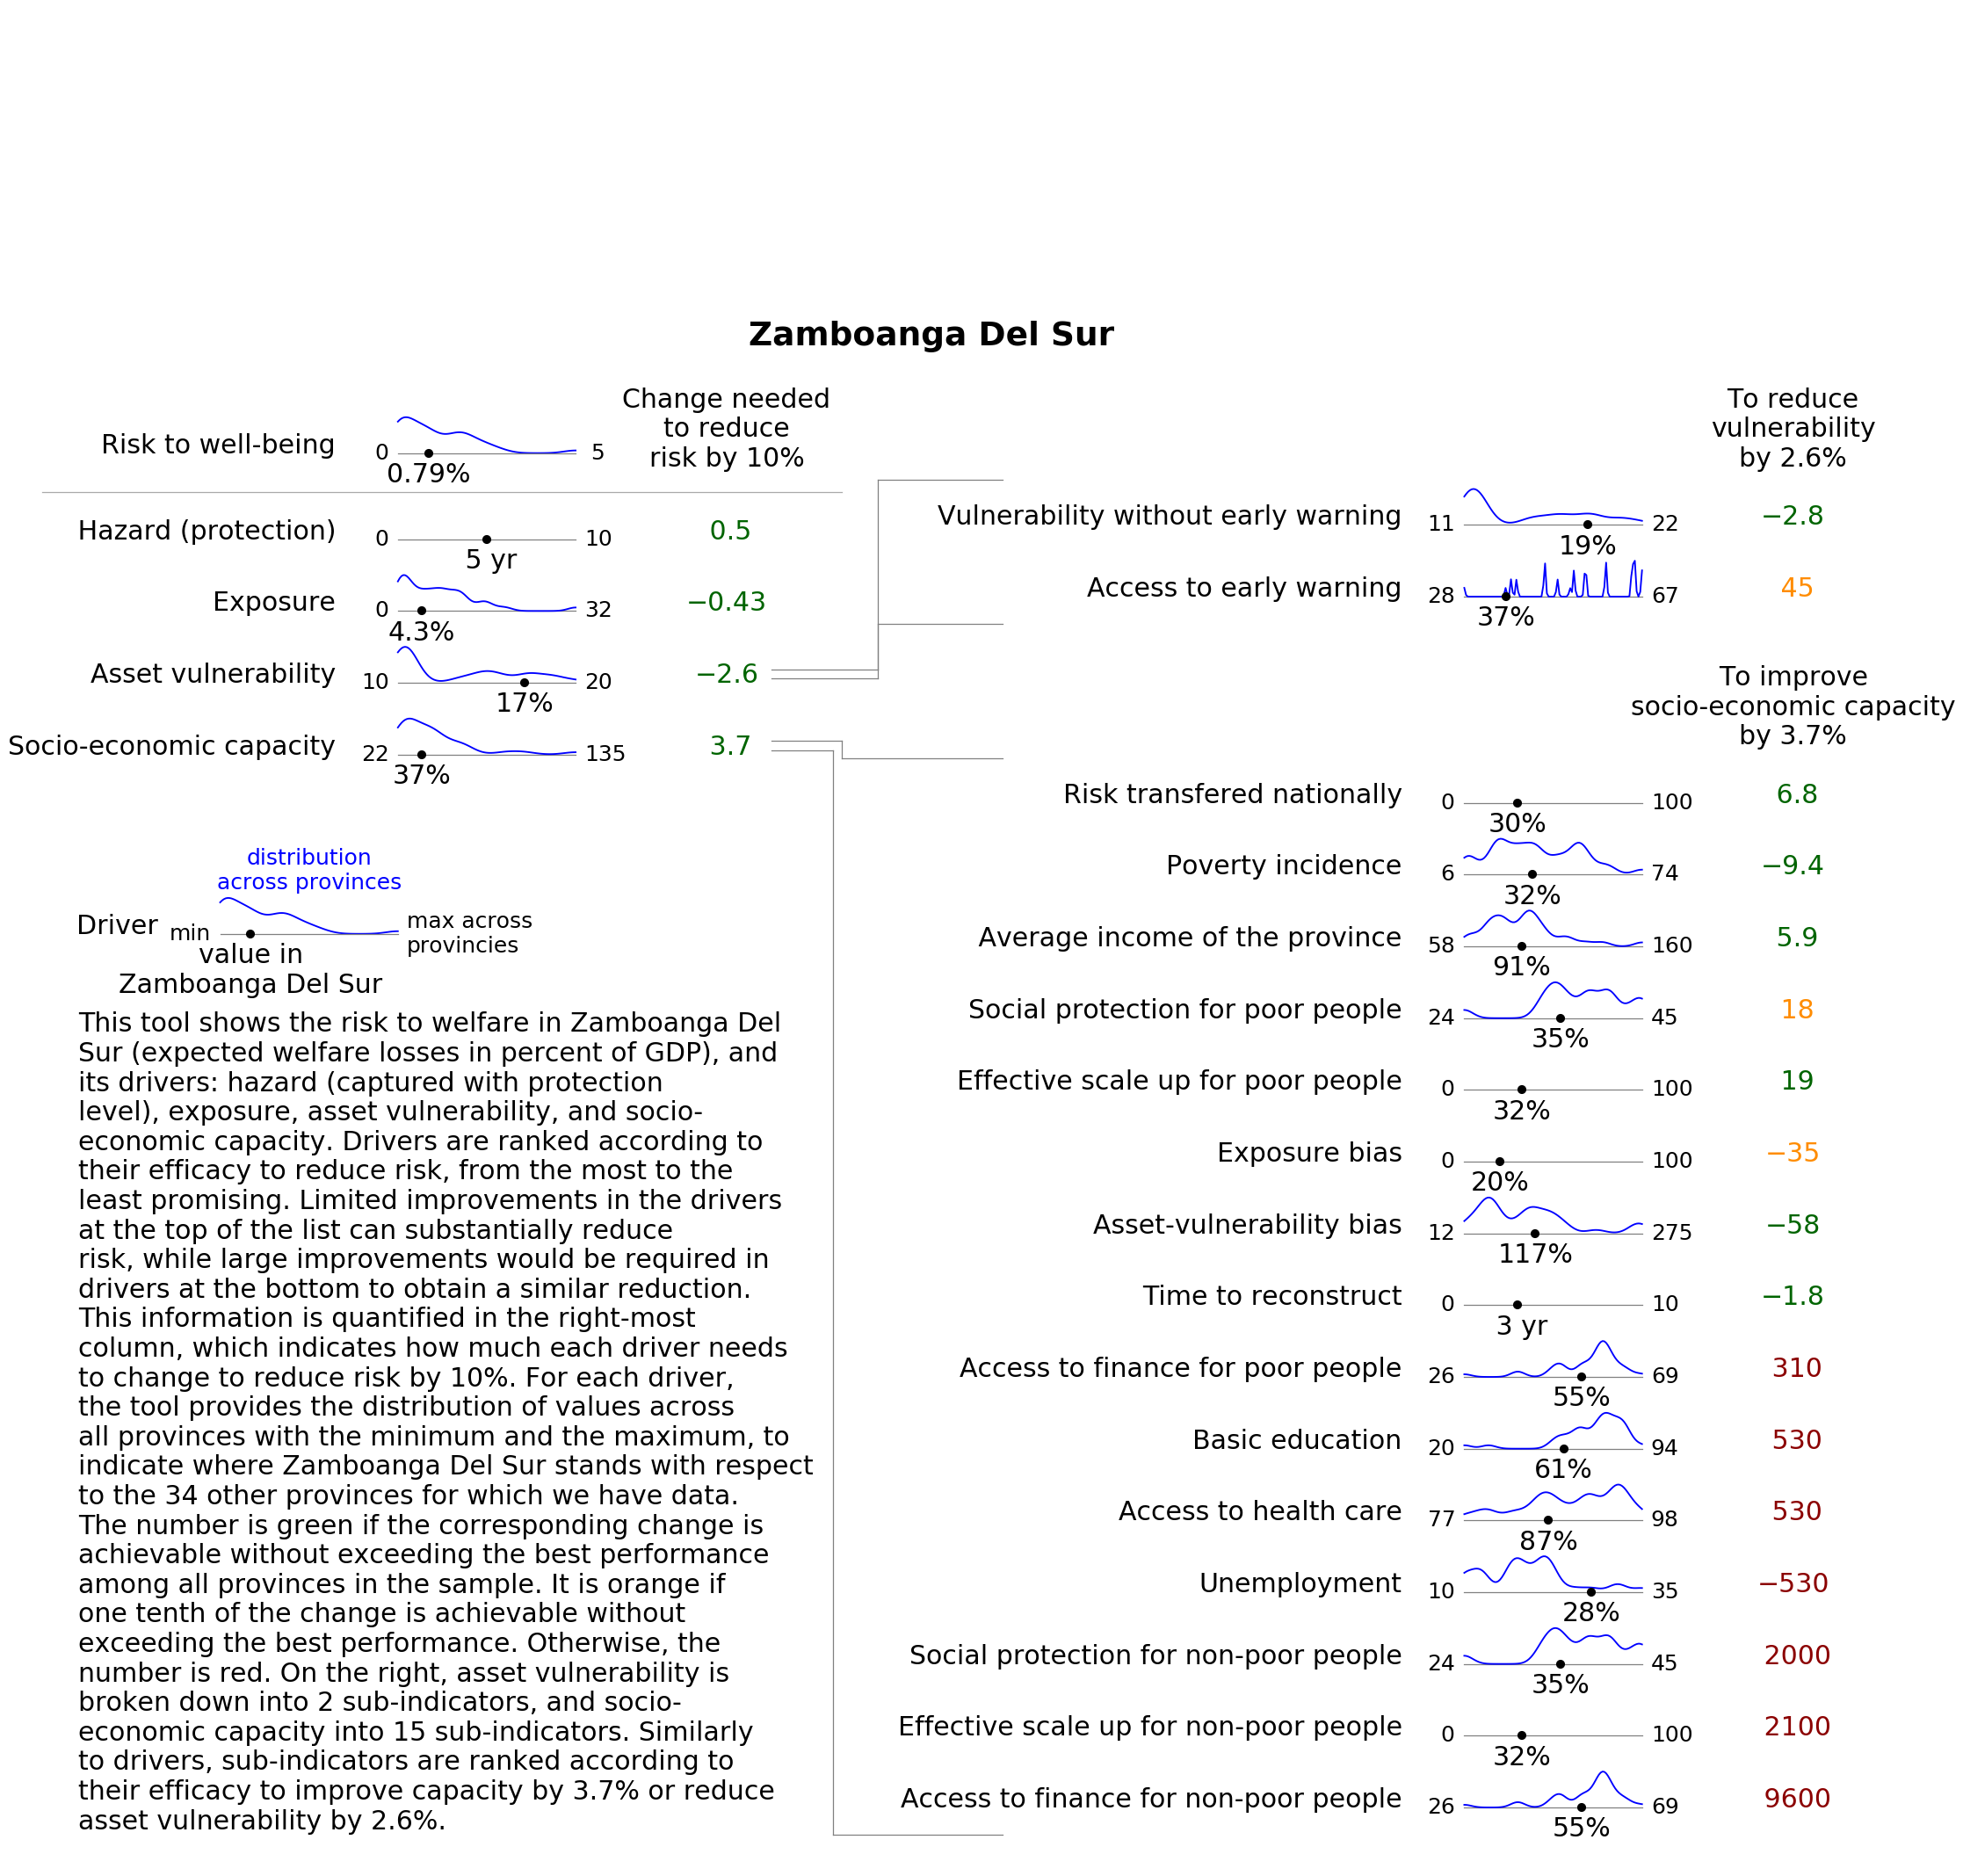

In [11]:
draw_scoracards(country_list.tolist());

Currently working on:  Batangas $(v= 6\%)$


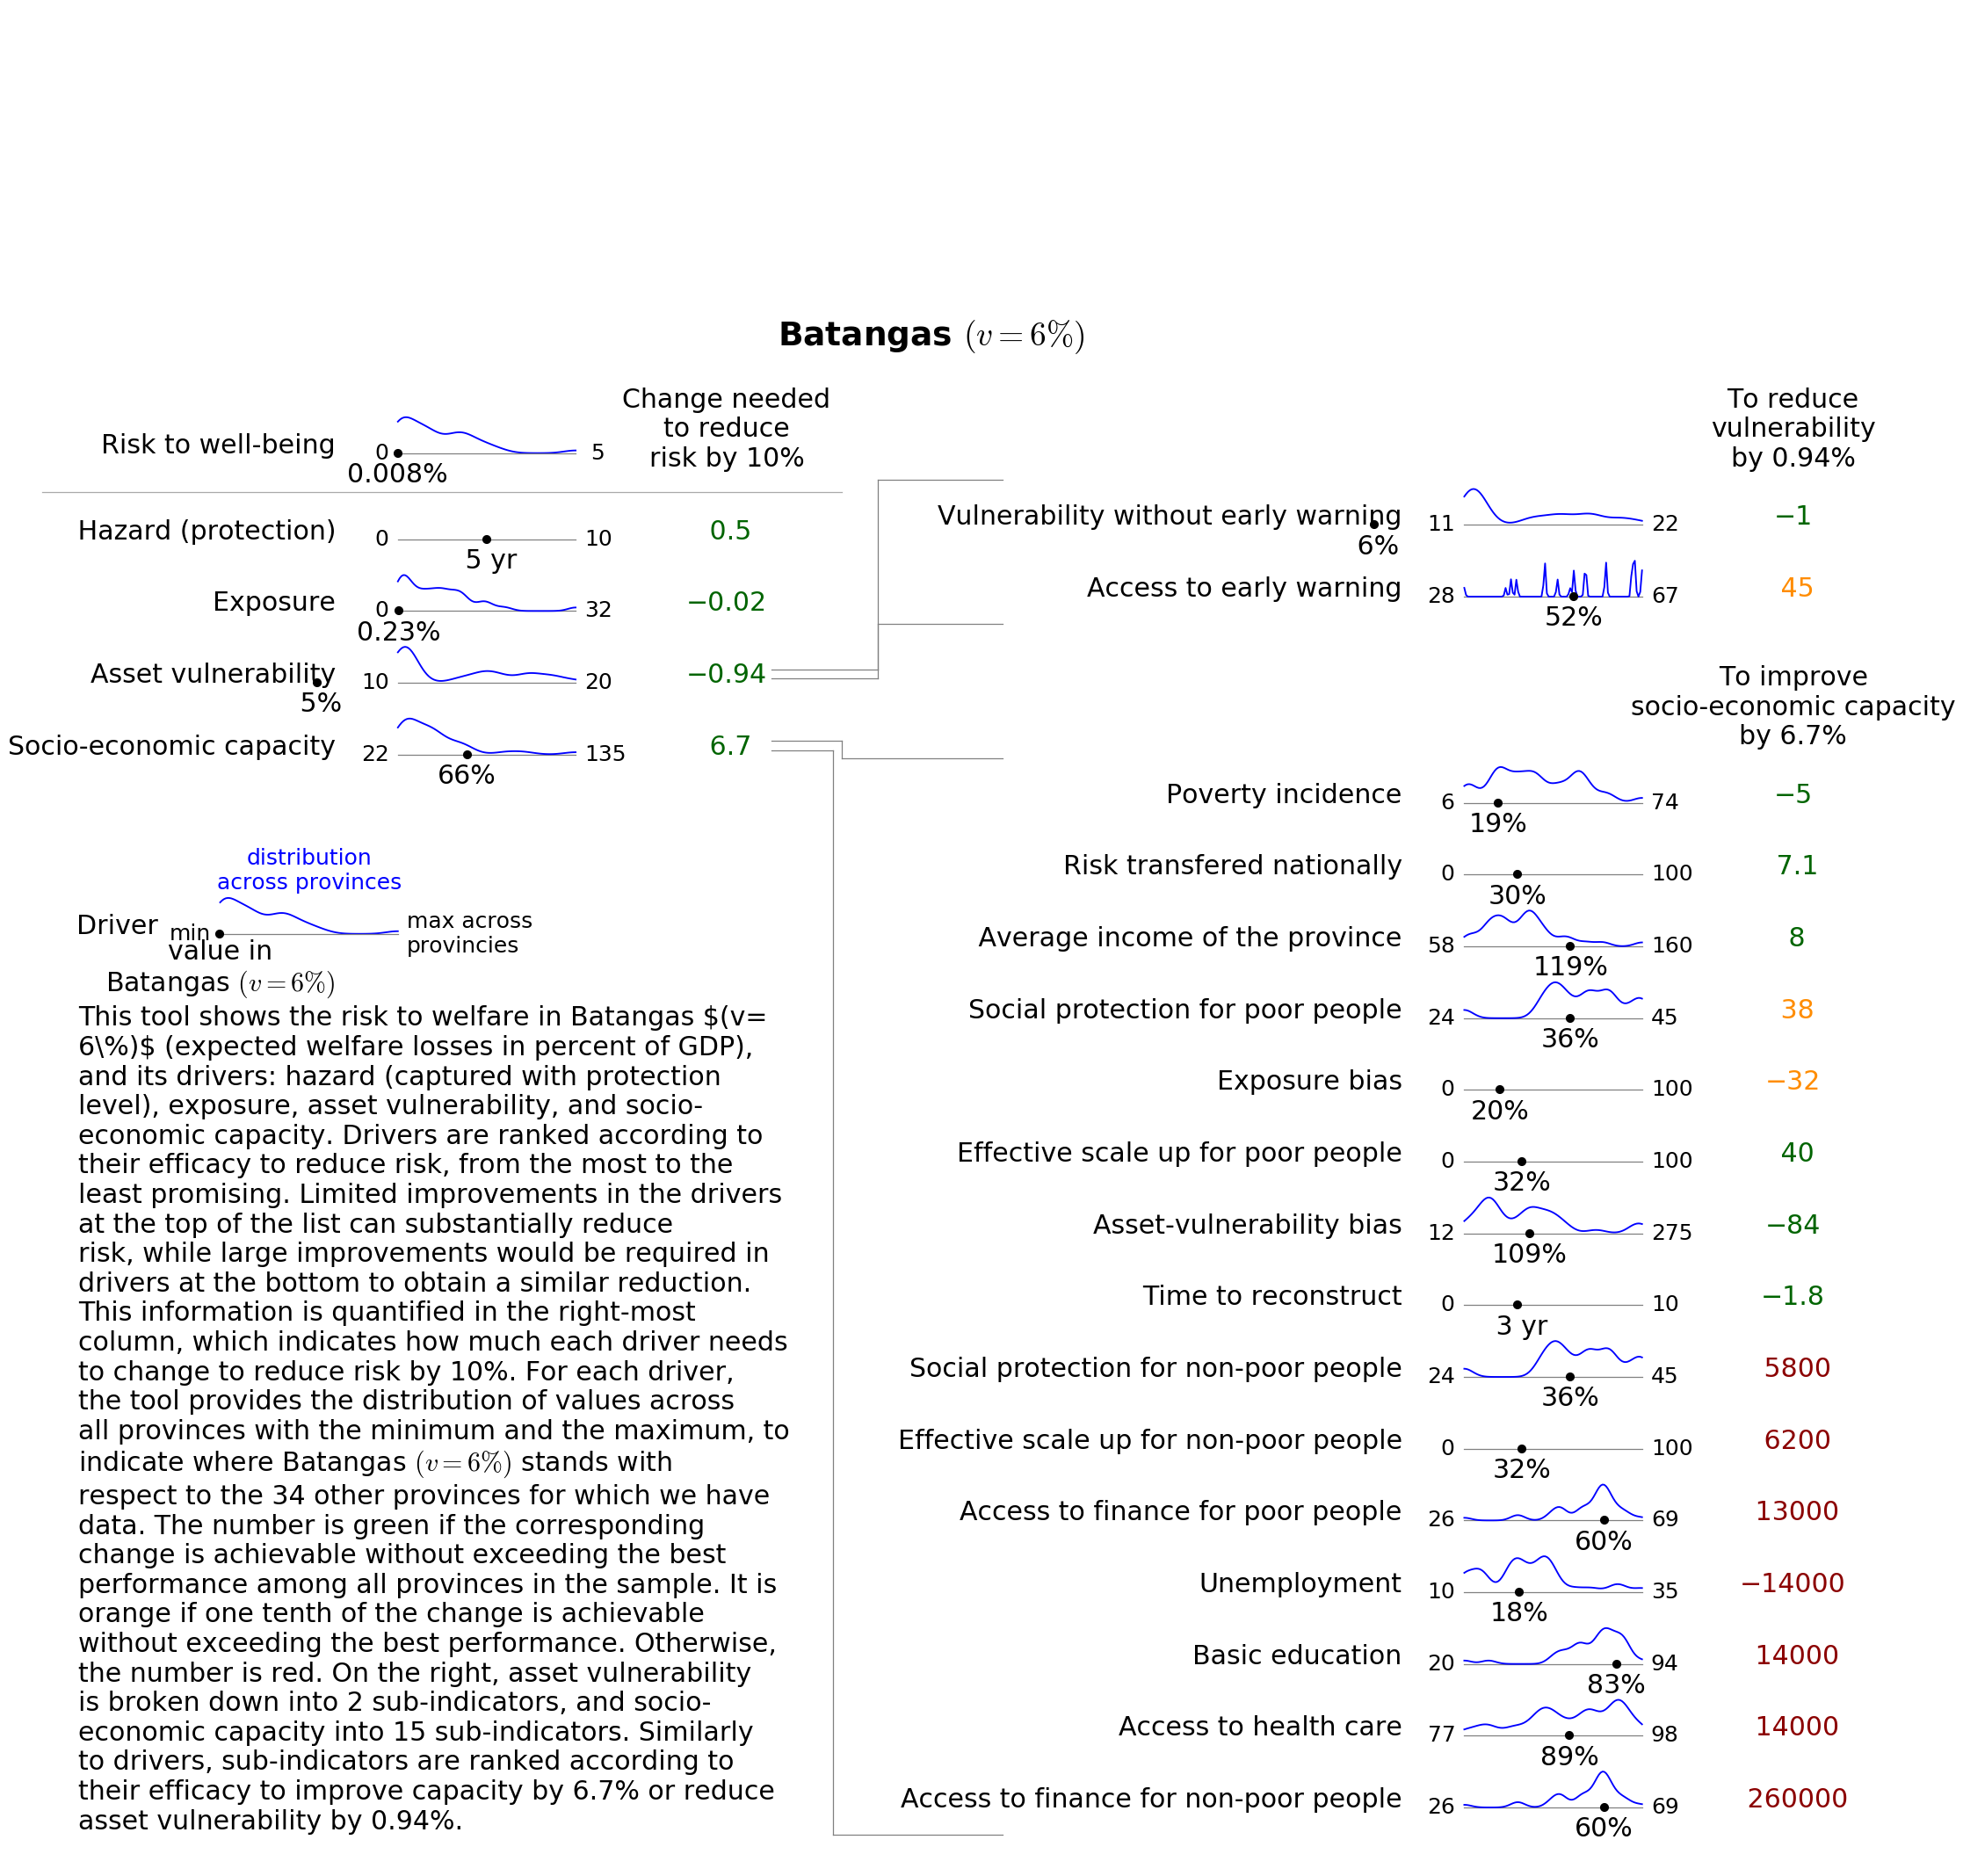

In [12]:
draw_scoracards(np.setdiff1d(country_list_sens,country_list).tolist())

### Merge to single pdf

In [13]:

#implements http://stackoverflow.com/questions/7102090/combining-pdf-files-with-ghostscript-how-to-include-original-file-names
import glob
from subprocess import call, Popen
import sys
from IPython.display import clear_output


def merge_scorecard_files(country_list,outputname):

    #goes to the write directory
    glob.os.chdir("scorecards/")

    command= ""
    i=1
    for name in country_list:
        command+="({name}) run [ /Page {page} /Title ({name}) /OUT pdfmark \n".format(name=file_name_formater(name)+".eps",page=i)
        i+=1

    with open("control.ps", "w") as text_file:
        text_file.write(command)

    #merges all eps to a PDF
    p=Popen("gswin64c -dEPSFitPage -sDEVICE=pdfwrite -o "+outputname+" control.ps");
    print("Merging scorecards....")
    sys.stdout.flush()

    p.communicate()

    print("Merging scorecards done")
    glob.os.chdir("..")

if True:
    
    #merges the eps in only one pdf
    merge_scorecard_files(country_list,"scorecards.pdf")
    merge_scorecard_files(country_list_sens,"scorecards_sens.pdf")
    

    

Merging scorecards....
Merging scorecards done
Merging scorecards....
Merging scorecards done
